## Example panan-rOM3 analysis notebook- `xgcm` loading

#### Using conda env xp65 analysis3-25.07

For `8km_jra_ryf_obc_Charrassin` experiment (MOM6-CICE6 panan 1/12th degree ~ 4km with no ice shelves)

**Note** Several non-standard uses of `esm_datastore`:

- `esm_datastore` was generated with a different branch to main to pick up incorrectly named files (see https://github.com/ACCESS-NRI/access-nri-intake-catalog/issues/459, thanks to Charles Turner for fixing this for me)
- Years 9 and 10 of this run used parallelised IO, and unfortunately the tiling resulted in NaNs along part of the y axis in these files. Therefore, we must use a preprocessing function that replaces these axes with that of an earlier time (month 0) (thanks to Jemma Jeffree for her help with this!)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from dask.distributed import Client
import intake
import cmocean as cm
from xgcm import Grid

In [2]:
client = Client(threads_per_worker = 1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39973 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39973/status,
Dashboard: /proxy/39973/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43221,Workers: 0
Dashboard: /proxy/39973/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:37009,Total threads: 1
Dashboard: /proxy/33877/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:45125,


Load datastore

In [3]:
esm_datastore = intake.open_esm_datastore(
    "/g/data/ol01/cy8964/access-om3/archive/8km_jra_ryf_obc_Charrassin/experiment_datastore.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

esm_datastore

,unique
filename,608
file_id,44
path,5088
filename_timestamp,131
frequency,3
start_date,240
end_date,241
variable,201
variable_long_name,183
variable_standard_name,39


List available diagnostics

In [4]:
variables = esm_datastore.unique().variable
print(variables)

['ANGLE', 'ANGLET', 'NCAT', 'VGRDa', 'VGRDb', 'VGRDi', 'VGRDs', 'aice', 'blkmask', 'congel', 'dvidtd', 'dvidtt', 'frazil', 'frzmlt', 'hi', 'hs', 'sifb', 'snoice', 'time', 'time_bounds', 'uvel', 'vvel', 'Tair_m', 'Tsfc_m', 'aice_m', 'aicen_m', 'albice_m', 'albsni_m', 'albsno_m', 'alidf_ai_m', 'alidr_ai_m', 'alvdf_ai_m', 'alvdr_ai_m', 'congel_m', 'daidtd_m', 'daidtt_m', 'divu_m', 'dvidtd_m', 'dvidtt_m', 'evap_ai_m', 'fcondtop_ai_m', 'fcondtopn_ai_m', 'fhocn_ai_m', 'flat_ai_m', 'flatn_ai_m', 'flwdn_m', 'flwup_ai_m', 'fmeltt_ai_m', 'fmelttn_ai_m', 'frazil_m', 'fresh_ai_m', 'frzmlt_m', 'fsalt_ai_m', 'fsalt_m', 'fsens_ai_m', 'fsensn_ai_m', 'fsurfn_ai_m', 'fswabs_ai_m', 'fswdn_m', 'fswthru_ai_m', 'fswup_m', 'hi_m', 'hs_m', 'ice_present_m', 'meltb_m', 'meltl_m', 'melts_m', 'meltt_m', 'opening_m', 'rain_ai_m', 'scale_factor_m', 'shear_m', 'sice_m', 'sifb_m', 'snoice_m', 'snow_ai_m', 'strairx_m', 'strairy_m', 'strcorx_m', 'strcory_m', 'strength_m', 'strintx_m', 'strinty_m', 'strocnx_m', 'strocny

Load month 0 specific datastore to get y axis info

In [5]:
mo0_esm_datastore = intake.open_esm_datastore(
    "/g/data/ol01/cy8964/access-om3/datastores/8km_jra_ryf_obc_Charrassin-output000/experiment_datastore.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

ds_good_yh = mo0_esm_datastore.search(variable="umo_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
good_yh_coords = ds_good_yh.yh.copy().load()
ds_good_yq = mo0_esm_datastore.search(variable="vmo_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
good_yq_coords = ds_good_yq.yq.copy().load()
def reset_y_coords(ds): #thanks to Jemma Jeffree for helping make this work!!
    ds = ds.assign_coords({'yh':good_yh_coords})
    ds = ds.assign_coords({'yq':good_yq_coords})
    return ds

When loading data that has a y-axis, you need to use the `preprocess` (and likely `decode_timedelta` too) arguments:
```
esm_datastore.search(variable="").to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True})
```

For example:

In [6]:
esm_datastore.search(variable="SSH").to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True})


<xarray.Dataset> Size: 3GB
Dimensions:  (time: 120, yh: 1442, xh: 4320)
Coordinates:
  * xh       (xh) float64 35kB -280.0 -279.9 -279.8 -279.7 ... 79.79 79.88 79.96
  * time     (time) object 960B 1900-01-16 12:00:00 ... 1909-12-16 12:00:00
  * yh       (yh) float64 12kB -86.49 -86.47 -86.45 ... -37.63 -37.56 -37.5
Data variables:
    SSH      (time, yh, xh) float32 3GB dask.array<chunksize=(1, 287, 434), meta=np.ndarray>
Attributes: (12/16)
    NumFilesInSet:                            1
    title:                                    ACCESS-OM3
    associated_files:                         areacello: access-om3.mom6.stat...
    grid_type:                                regular
    grid_tile:                                N/A
    intake_esm_vars:                          ['SSH']
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   area:mean yh:mean xh:mean time:...
    intake_esm_attrs:variable_units:          m,days,days since 1900-01-01 00...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_mom6_2d_SSH_1mon_mea...

In [7]:
esm_datastore.search(variable="vo").to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True})


<xarray.Dataset> Size: 224GB
Dimensions:  (time: 120, z_l: 75, yq: 1443, xh: 4320)
Coordinates:
  * xh       (xh) float64 35kB -280.0 -279.9 -279.8 -279.7 ... 79.79 79.88 79.96
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time     (time) object 960B 1900-01-16 12:00:00 ... 1909-12-16 12:00:00
  * yq       (yq) float64 12kB -86.5 -86.48 -86.46 ... -37.59 -37.53 -37.46
Data variables:
    vo       (time, z_l, yq, xh) float32 224GB dask.array<chunksize=(1, 15, 144, 217), meta=np.ndarray>
Attributes: (12/18)
    NumFilesInSet:                            1
    title:                                    ACCESS-OM3
    associated_files:                         areacello: access-om3.mom6.stat...
    grid_type:                                regular
    grid_tile:                                N/A
    intake_esm_vars:                          ['vo']
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ideal_age_tracer,,,,,,,sea_wate...
    intake_esm_attrs:variable_cell_methods:   area:mean z_l:mean yh:mean xh:m...
    intake_esm_attrs:variable_units:          yr,days,days since 1900-01-01 0...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean_month_z.1mon

### Loading other model data from the intake catalogue for comparison

Let's load in the mom6 panan01 and panan005 models, as well as ACCESS-OM2-01-RYF (potentially there is a more suitable one with more diagnostics starting from WOA but it's not on intake?)

In [8]:
catalog = intake.cat.access_nri

In [9]:
catalog.search(model="ACCESS-OM2-01", frequency="1mon",name="01deg_jra55v13_ryf9091")


,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v13_ryf9091,{ACCESS-OM2-01},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{seaIce, ocean}",{1mon},"{temp_vdiffuse_diff_cbt_conv, frazil_m, total_ocean_river, hs_m, grid_xu_ocean, tx_trans_int_z, uvel_m, pot_rho_2, grid_yt_ocean, fsalt_ai_m, sst_m, strength_m, temp_global_ave, evap_heat, total_o..."


In [10]:
'''
names of panant models
panant-01-zstar-ACCESSyr2
panant-005-zstar-ACCESSyr2
panant-0025-zstar-ACCESSyr2
'''
catalog.search(name = "panant-01-zstar-ACCESSyr2")


,model,description,realm,frequency,variable
name,,,,,
panant-01-zstar-ACCESSyr2,"{MOM6, SIS2}",{0.1 degree (MOM6+SIS2) Pan-Antarctic regional model configuration under 1990-1991 JRA55-do repeat year forcing.},"{seaIce, ocean}","{1day, 1mon, fx}","{col_height, volcello, diffu, tauy, geolat_v, tauvo, gKEu, geolon_u, geolat, lrunoff, intz_diffu_2d, v_BT_accel, dxCu, z_l, time, intz_gKEu_2d, siconc, yq, areacello_cu, rhopot0, geolat_c, Kd_salt..."


# Example: interpolate uo and vo onto same grid 

In [11]:
# define chunks dict
chunks_dict = {
	        'time' : 1,
	        'yq' : 1443,
	        'xq' : 4321,
            'yh':1442,
            'xh':4320
	    }

In [12]:
# load new panan
# need to say what chunks are in the xarray_open_kwargs
panantrom3_vo = esm_datastore.search(variable="vo", frequency = '1mon').to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True,'chunks' : chunks_dict},)

panantrom3_uo = esm_datastore.search(variable="uo", frequency = '1mon').to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True,'chunks' : chunks_dict},)


In [13]:
# load an ocean_month_z file which has all the grid info
panantrom3_ds = xr.open_mfdataset('/g/data/ol01/cy8964/access-om3/archive/8km_jra_ryf_obc_Charrassin/output114/ocean_month_z.nc',
	                                  preprocess=reset_y_coords, decode_timedelta = False, chunks = chunks_dict)

In [19]:
# define an xgcm grid
# need to drop time dimension
grid = Grid(panantrom3_ds.isel(time = 0).drop_vars('time'),coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"z_l","outer":"z_i"}},periodic="x")
	
	


In [20]:
panantrom3_vo_interp = grid.interp(panantrom3_vo.vo,'y',boundary='extend')


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [21]:
panantrom3_uo_interp = grid.interp(panantrom3_vo.vo,'y',boundary='extend')


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [22]:
panantrom3_vo_interp

<xarray.DataArray 'vo' (time: 120, z_l: 75, yh: 1442, xh: 4320)> Size: 224GB
dask.array<transpose, shape=(120, 75, 1442, 4320), dtype=float32, chunksize=(1, 15, 1442, 4320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 960B 1900-01-16 12:00:00 ... 1909-12-16 12:00:00
  * xh       (xh) float64 35kB -280.0 -279.9 -279.8 -279.7 ... 79.79 79.88 79.96
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * yh       (yh) float64 12kB -86.49 -86.47 -86.45 ... -37.63 -37.56 -37.5

In [23]:
panantrom3_uo_interp

<xarray.DataArray 'vo' (time: 120, z_l: 75, yh: 1442, xh: 4320)> Size: 224GB
dask.array<transpose, shape=(120, 75, 1442, 4320), dtype=float32, chunksize=(1, 15, 1442, 4320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 960B 1900-01-16 12:00:00 ... 1909-12-16 12:00:00
  * xh       (xh) float64 35kB -280.0 -279.9 -279.8 -279.7 ... 79.79 79.88 79.96
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * yh       (yh) float64 12kB -86.49 -86.47 -86.45 ... -37.63 -37.56 -37.5

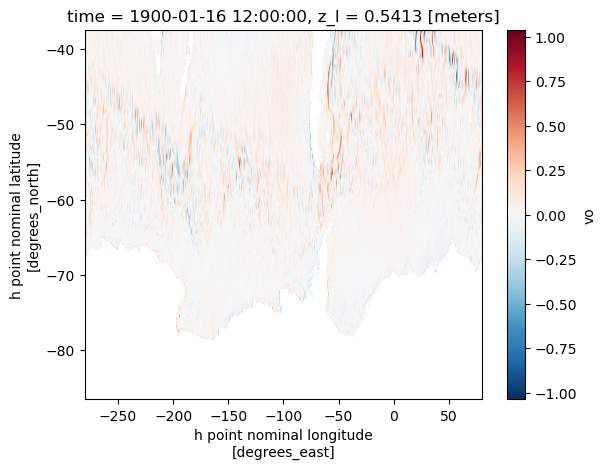

In [24]:
panantrom3_uo_interp.isel(time = 0,z_l = 0).plot()